### subject 별로 폴더 생성 -> 각 subject 폴더 안에 epoch 데이터를 분리하여 h5 파일로 저장

In [ ]:
import os, h5py
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from utils import add_zero_to_id, load_single_ppg, pad_and_create_mask

path_prepro = 'Y:/MESA_0.7.0/ppg_preprocessed'
df_psm = pd.read_csv("./df_delected_psm.csv", index_col=0)

list_fn = os.listdir(path_prepro)
sr_fn = pd.Series(list_fn)

def epoching(id, ppg, label):
    # generate directory to be saved
    path_save = os.path.join('Y:/MESA_0.7.0/ppg_preprocessed_epoch', add_zero_to_id(id))
    os.makedirs(path_save, exist_ok=True)

    sampling_rate = 34.13  # Hz
    epoch_duration = 30  # seconds
    samples_per_epoch = int(epoch_duration * sampling_rate) # 30초 동안의 샘플 수 계산

    # 신호 길이를 나눌 수 있는 최대 epoch 수로 잘라냄
    num_epochs = len(ppg) // samples_per_epoch
    truncated_signal = ppg[:num_epochs * samples_per_epoch]

    # epoching
    for i in range(num_epochs):
        start_idx = i * samples_per_epoch
        end_idx = start_idx + samples_per_epoch
        epoch = truncated_signal[start_idx:end_idx]

        with h5py.File(os.path.join(path_save, f'epoch_{i}.h5'), "w") as hdf:
            hdf.create_dataset("epoch", data=epoch)
    
    # same labels for each epoch
    labels = [label] * num_epochs
    path_save_labels = os.path.join('Y:/MESA_0.7.0/labels_epoch', add_zero_to_id(id))
    os.makedirs(path_save_labels, exist_ok=True)

    with h5py.File(os.path.join(path_save_labels, 'labels_for_epochs.h5'), "w") as hdf:
        hdf.create_dataset("epoch", data=labels)

# Load data
list_ppg = []
list_labels = []
for id in tqdm(df_psm.index): # df_psm의 id 순서대로 파일 업로드
    if sr_fn.str.contains(add_zero_to_id(id)).sum() > 0: # id와 match되는 파일인 경우, 업로드
        ppg = load_single_ppg(os.path.join(path_prepro, 'mesa-sleep-%s.h5' % add_zero_to_id(id))) # ppg data append
        label = df_psm.loc[id, 'insmnia5'] # a label 

        epoching(id, ppg, label)

### Demo for my_dataset.py 
1. 모든 subject의 모든 epoch 데이터와 epoch label 데이터를 load
2. 이 들을 쭉 이어 붙여서 하나의 numpy array 형성
-> [num_epochs, fs*30s]의 shape를 가질 것임
3. label도 마찬가지로 합쳐서 하나의 numpy array 형성
-> [num_epochs, 1]

In [64]:
import os, h5py
import numpy as np
from tqdm.notebook import tqdm

path_ppg_subjects = 'Y:/MESA_0.7.0/ppg_preprocessed_epoch'
path_label_subjects = 'Y:/MESA_0.7.0/labels_epoch'
list_subjects_dir = os.listdir(path_ppg_subjects)
print("num subjects: {}".format(len(list_subjects_dir)))

list_epochs_total = []
list_labels_total = []
for subject_id in tqdm(list_subjects_dir):
    path_subject_ppg = os.path.join(path_ppg_subjects, subject_id)
    path_subject_label = os.path.join(path_label_subjects, subject_id)
    list_fnames = os.listdir(path_subject_ppg)

    # subject_id에 해당하는 모든 epoch에 대한 ppg 및 label 데이터 업로드
    for fname in list_fnames:
        # upload ppg data for each epoch
        path_ppg = os.path.join(path_subject_ppg, list_fnames[1])
        with h5py.File(path_ppg, "r") as hdf:
            list_epochs_total.append(hdf["epoch"][:])

    # upload label data for each epoch
    path_label = os.path.join(path_subject_label, 'labels_for_epochs.h5')
    with h5py.File(path_label, "r") as hdf:
        list_labels_total.append(hdf["epoch"][:])

num subjects: 198


  0%|          | 0/198 [00:00<?, ?it/s]

In [69]:
arr_ppg_epochs = np.array(list_epochs_total)
arr_label_epochs = np.concatenate(list_labels_total)

print(arr_ppg_epochs.shape)
print(arr_label_epochs.shape)

path_npy = 'Y:/MESA_0.7.0/ppg_preprocessed_epoch_npy'
np.save(os.path.join(path_npy, 'ppg_epochs.npy'), arr_ppg_epochs)
np.save(os.path.join(path_npy, 'label_epochs.npy'), arr_label_epochs)

(249265, 1023)
(249265,)


In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split

# Custom Dataset 생성
class gen_dataset(Dataset):
    def __init__(self, num_classes=2, sampling_rate=34.13, path_load = 'Y:/MESA_0.7.0/ppg_preprocessed_epoch_npy'):
                    
        self.data = torch.from_numpy(np.load(os.path.join(path_load, "ppg_epochs.npy")))
        self.label = torch.from_numpy(np.load(os.path.join(path_load, "label_epochs.npy")))

        self.num_samples = self.data.shape[0]
        self.num_classes = num_classes
        self.sampling_rate = sampling_rate 

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        data = self.data[idx]
        label = self.label[idx]

        return data, label

In [ ]:
# hyperparameters
learning_rate = 0.0001
num_epochs = 100
batch_size = 256

my_dataset = gen_dataset()

# Train, Validation, Test Split
total_size = len(my_dataset)

train_size = int(0.7 * total_size)
val_size = total_size - train_size

generator1 = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(my_dataset, [train_size, val_size], generator=generator1)

In [5]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
print('training set:{}\nvalidation set:{}'.format(len(train_dataset), len(val_dataset)))

training set:174485
validation set:74780


In [71]:
data = np.load(os.path.join(path_npy, 'ppg_epochs.npy'))
label = np.load(os.path.join(path_npy, 'label_epochs.npy'))

### parallel version

In [43]:
import os
import h5py
import numpy as np
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

# 데이터 경로 설정
path_ppg_subjects = 'Y:/MESA_0.7.0/ppg_preprocessed_epoch'
path_label_subjects = 'Y:/MESA_0.7.0/labels_epoch'
list_subjects_dir = os.listdir(path_ppg_subjects)
print("num subjects: {}".format(len(list_subjects_dir)))

def process_subject(subject_id):
    """각 subject_id에 대해 PPG와 Label 데이터를 읽어 리스트로 반환"""
    list_epochs = []
    list_labels = []
    
    # 경로 설정
    path_subject_ppg = os.path.join(path_ppg_subjects, subject_id)
    path_subject_label = os.path.join(path_label_subjects, subject_id)
    list_fnames = os.listdir(path_subject_ppg)
    
    for fname in list_fnames:
        # PPG 데이터 읽기
        path_ppg = os.path.join(path_subject_ppg, fname)
        with h5py.File(path_ppg, "r") as hdf:
            list_epochs.append(hdf["epoch"][:])
        
        # Label 데이터 읽기
        path_label = os.path.join(path_subject_label, 'labels_for_epochs.h5')
        with h5py.File(path_label, "r") as hdf:
            list_labels.append(hdf["epoch"][:])
    
    return list_epochs, list_labels

# 병렬 실행
results = Parallel(n_jobs=-1, backend="loky")(
    delayed(process_subject)(subject_id) for subject_id in tqdm(list_subjects_dir)
)

# 결과 병합
list_epochs_total_par = []
list_labels_total_par = []

for list_epochs, list_labels in results:
    list_epochs_total_par.extend(list_epochs)
    list_labels_total_par.extend(list_labels)

print("Total epochs:", len(list_epochs_total_par))
print("Total labels:", len(list_labels_total_par))


num subjects: 198


  0%|          | 0/198 [00:00<?, ?it/s]

Total epochs: 249265
Total labels: 249265


In [25]:
import numpy as np

path_epoch = os.path.join(path_subject, list_fnames[1])
with h5py.File(path_epoch, "r") as hdf:
    data = hdf["epoch"][:]

print(data.shape)
print(type(data))


list_epochs_total = []

# subject 1
list_subject_epochs = []
for fname in tqdm(list_fnames):
    path_epoch = os.path.join(path_subject, list_fnames[1])
    with h5py.File(path_epoch, "r") as hdf:
        list_subject_epochs.append(hdf["epoch"][:])

list_epochs_total += list_subject_epochs
print(len(list_epochs_total))
    
# subejct 2
list_subject_epochs = []
for fname in tqdm(list_fnames):
    path_epoch = os.path.join(path_subject, list_fnames[1])
    with h5py.File(path_epoch, "r") as hdf:
        list_subject_epochs.append(hdf["epoch"][:])

list_epochs_total += list_subject_epochs
print(len(list_epochs_total))

(1023,)
<class 'numpy.ndarray'>


  0%|          | 0/1080 [00:00<?, ?it/s]

1080


  0%|          | 0/1080 [00:00<?, ?it/s]

2160


11.999438421720871
9.999715141452613
9.999715141452613
6.999715141452615
11.999715141452613


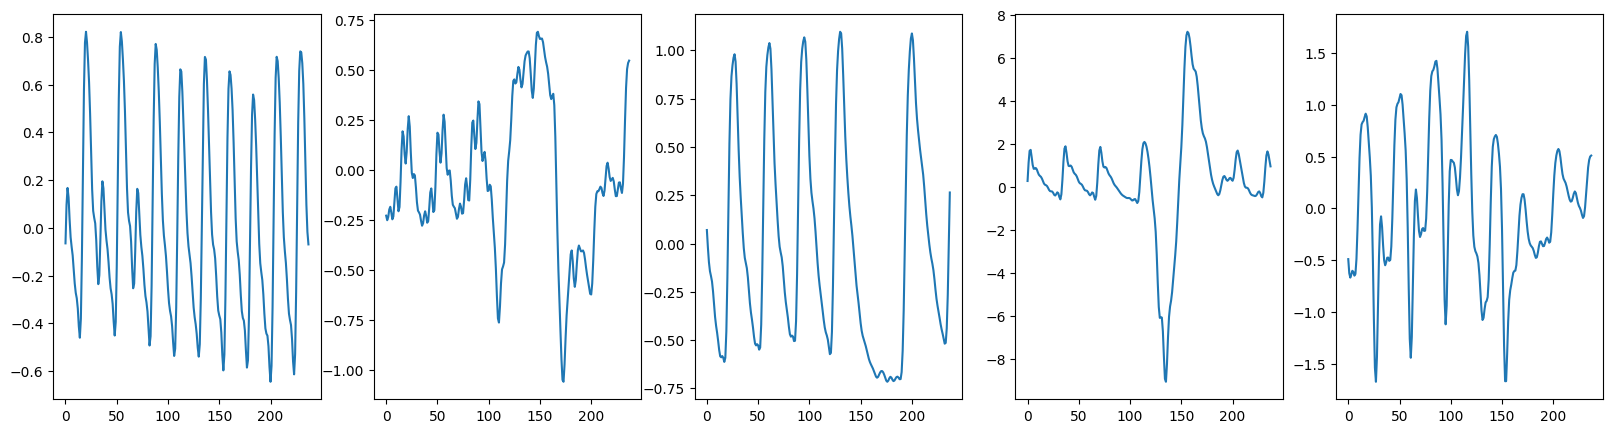

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 5, figsize=(20,5))

for i, ppg in enumerate(list_ppg[:5]):
    # ppg = list_ppg[4]
    print(ppg.shape[0]/34.13/60/60)

    fs = int(34.13)
    idx = range(fs*3, fs*10)
    axs[i].plot(ppg[idx])